In [474]:
import pandas as pd
import numpy as np

#Regex
import re
import string

#Ploting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS

#Creating DTM
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Dimensionality reduction / matrix decomposition
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA

#Stemming/lemmatizing
from nltk.stem.lancaster import LancasterStemmer

from nltk import sent_tokenize
import spacy

#Cosine similarity
from scipy.spatial import distance

import pickle

In [115]:
review_df = pd.read_csv("raw_yelp_review_data.csv")

In [4]:
review_df.sample(10)

,coffee_shop_name,full_review_text,star_rating
6006,La Tazza Fresca,12/15/2013 1 check-in Great place to study wi...,4.0 star rating
6838,Teo,6/21/2015 1 check-in Had the best carmel macc...,5.0 star rating
857,Brian’s Brew,12/19/2012 I love this hidden gem! The lattes...,5.0 star rating
2361,Anderson’s Coffee Company,"4/30/2014 I can't speak about their coffee, b...",1.0 star rating
3397,Arturo’s Underground Cafe,5/13/2016 This place was ok. The building def...,3.0 star rating
2319,Mary’s Cafe,1/24/2015 We went for the grand opening recen...,5.0 star rating
2943,Thunderbird Coffee,11/10/2014 1 check-in Atmosphere = 5 stars Co...,4.0 star rating
6365,Pacha,12/11/2015 Best pancakes ever! With pancakes ...,5.0 star rating
825,Café Crème,2/19/2014 16 check-ins Oh please let this sta...,4.0 star rating
1581,Mañana Coffee & Juice,2/4/2016 First to Review Listed in dinewithsh...,5.0 star rating


In [174]:
review_df.rename(columns={"coffee_shop_name":"SHOP", "full_review_text":"REVIEW", "star_rating":"RATING"}, inplace=True)

In [175]:
review_df.sample(3)

,SHOP,REVIEW,RATING
6651,Juan Pelota,"7/28/2010 Small, quaint neighborhood coffee s...",4.0 star rating
2598,Flightpath Coffeehouse,1/1/2016 Stumbled upon this coffeehouse while...,5.0 star rating
3251,Cherrywood Coffeehouse,4/28/2016 My gfs set me up on a date here whi...,3.0 star rating


In [463]:
review_df.shape

(7616, 7)

In [419]:
review_df["SHOP"].unique()

array(['The Factory - Cafe With a Soul',
       'The Marvelous Vintage Tea Party Co.', 'Vintage Heart Coffee',
       'Fleet Coffee', 'Mozart’s Coffee Roasters',
       'Summer Moon Coffee Bar', 'Monkey Nest Coffee',
       'Apanas Coffee & Beer', 'Corona Coffee', 'Café Crème',
       'Brian’s Brew', 'Legend Coffee', 'Venezia Italian Gelato',
       'Epoch Coffee', 'Houndstooth Coffee', 'Caffe Medici',
       'Flitch Coffee', 'Holy Grounds', 'Figure 8 Coffee Purveyors',
       'Mañana Coffee & Juice', 'Fat Cats Organic Coffee And Dessert',
       'Flat Track Coffee', 'Mary’s Cafe', 'Anderson’s Coffee Company',
       'Flightpath Coffeehouse', 'Third Coast Coffee Roasting Company',
       'Bennu Coffee', 'Dolce Neve', 'Thunderbird Coffee', 'Halcyon',
       'Cherrywood Coffeehouse', 'Jo’s Coffee',
       'Arturo’s Underground Cafe', 'Patika', 'Cenote',
       'The Hideout Coffeehouse', 'Lucky Lab Coffee', 'Cream Whiskers',
       'Lola Savannah Coffee Lounge', 'Seventh Flag Coffee Co',


In [420]:
#Reconcile names of shops

name_dict = {"Summermoon Coffee Bar":"Summer Moon Coffee Bar", "Caffé Medici":"Caffe Medici"}

review_df["SHOP"] = review_df.SHOP.apply(
                                lambda x: x.strip() if x.strip() not in name_dict else name_dict[x.strip()])


In [248]:
review_df.RATING = review_df.RATING.apply(lambda x: int(x.strip()[0]))

In [249]:
review_df.RATING.value_counts()

5    3780
4    2360
3     738
2     460
1     278
Name: RATING, dtype: int64

In [250]:
#Removes all non-letter characters, removes the phrase check-in and puts it to lowercase
def clean_text(s):
    s = s.lower()
    s = s.replace("check-ins","")
    s = s.replace("check-in","")
    s = re.sub('[%s]' % re.escape(string.punctuation), ' ', s)
    s = re.sub('[%s]' % re.escape(string.digits), ' ', s)
    return s


In [251]:
review_df["CLEAN_REVIEW"] = review_df.REVIEW.apply(clean_text)

In [252]:
review_df.sample(5)

,SHOP,REVIEW,RATING,CLEAN_REVIEW
7386,Live Oak Market,9/13/2014 1 check-in The sandwiches here are ...,5,the sandwiches here are top notc...
1542,Figure 8 Coffee Purveyors,11/24/2015 This place is as good as it gets. ...,5,this place is as good as it gets ...
7418,Hot Mama’s Cafe,8/22/2016 Listed in 2016 Yelp 100! I've actua...,4,listed in yelp i ve actua...
6541,Quack’s 43rd Street Bakery,5/30/2015 1 check-in This is the ole school t...,4,this is the ole school town coff...
4519,Friends & Neighbors,9/24/2014 I was really excited about coming h...,3,i was really excited about coming h...


In [14]:
analyzer = SentimentIntensityAnalyzer()
review_df['SENTIMENT'] = review_df.CLEAN_REVIEW.map(analyzer.polarity_scores).map(lambda x: x.get('compound'))
review_df.sample(5)

,SHOP,REVIEW,RATING,CLEAN_REVIEW,SENTIMENT
4021,Seventh Flag Coffee Co,"5/21/2016 I'm not a big coffee drinker, and I...",5,i m not a big coffee drinker and i...,0.9443
6497,Quack’s 43rd Street Bakery,2/11/2016 1 check-in Gosh I was really hoping...,2,gosh i was really hoping their s...,0.9763
6782,Teo,4/13/2016 2 check-ins My favorite gelato plac...,4,my favorite gelato place in aust...,0.9613
2277,Mary’s Cafe,11/7/2015 1 check-in Love this little place. ...,5,love this little place it has e...,0.9377
3756,The Hideout Coffeehouse,"4/17/2011 The best coffee house downtown, by ...",5,the best coffee house downtown by ...,0.7003


In [15]:
review_df[review_df.RATING == 5].SENTIMENT.mean()

0.8953088359788353

In [16]:
review_df.shape

(7616, 5)

In [17]:
review_df.CLEAN_REVIEW.apply(lambda x: len(x.split())).sum()

787126

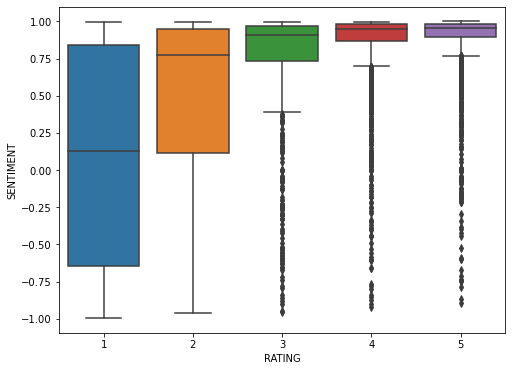

In [18]:
plt.figure(figsize=(8,6))
sns.boxplot(y="SENTIMENT", x="RATING", data=review_df)
plt.savefig("sentiment_by_rating.png", format='png', dpi=150)

Creating the Document term matrix

In [19]:
tfidf_cv = TfidfVectorizer(stop_words = 'english', min_df = 1/7000)
X = tfidf_cv.fit_transform(review_df.CLEAN_REVIEW)
dtm = pd.DataFrame(X.toarray(), columns=tfidf_cv.get_feature_names())

In [20]:
dtm.head()

,aa,aamil,aback,abandoned,ability,able,abound,abrasive,abroad,abrupt,...,zen,zero,zest,zesty,zhi,zip,zombies,zone,zoom,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
dtm.shape

(7616, 9602)

Let's do our topic modeling now

In [22]:
lsa = TruncatedSVD(n_components = 10)
lsa.fit(dtm)

TruncatedSVD(n_components=10)

We'll display the top words for each topic

In [23]:
for i in range(len(lsa.components_)):
    topic = lsa.components_[i]
    common_indices = np.argpartition(topic, -10)[-10:]
    common_words = [tfidf_cv.get_feature_names()[j] for j in common_indices]
    print(common_words)

['friendly', 'just', 'love', 'austin', 'really', 'great', 'coffee', 'like', 'good', 'place']
['try', 'like', 'ice', 'got', 'sweet', 'tea', 'cream', 'chocolate', 'gelato', 'flavors']
['amazing', 'love', 'awesome', 'staff', 'great', 'place', 'flavors', 'friendly', 'breakfast', 'gelato']
['flavors', 've', 'iced', 'austin', 'favorite', 'moon', 'best', 'gelato', 'shop', 'coffee']
['moon', 'delicious', 'latte', 'chai', 'tea', 'milk', 'breakfast', 'tacos', 'iced', 'great']
['order', 'sandwich', 'morning', 'good', 'just', 'coffee', 'food', 'breakfast', 'taco', 'tacos']
['friendly', 'coffee', 'iced', 'tacos', 'gelato', 'latte', 'good', 'breakfast', 'really', 'nice']
['boba', 'chocolate', 'chicken', 'ice', 'puff', 'puffs', 'good', 'coffee', 'tea', 'cream']
['breakfast', 'cookie', 'moon', 'vanilla', 'great', 'ice', 'cream', 'latte', 'puff', 'puffs']
['time', 'good', 'great', 'customer', 'really', 'service', 'moon', 'atmosphere', 'milk', 'gelato']


Some of these make some sense, but we can do better. Let's 
1. Eliminate very common words
2. Look at 2-grams
3. Lemmatize

Eliminate common words

In [24]:
tfidf_cv = TfidfVectorizer(stop_words = "english", min_df = 1/7000, max_df = .7)
X = tfidf_cv.fit_transform(review_df.CLEAN_REVIEW)
dtm = pd.DataFrame(X.toarray(), columns=tfidf_cv.get_feature_names())

In [25]:
lsa = TruncatedSVD(n_components = 5)
lsa.fit(dtm)

TruncatedSVD(n_components=5)

In [26]:
for i in range(len(lsa.components_)):
    topic = lsa.components_[i]
    common_indices = np.argpartition(topic, -10)[-10:]
    common_words = [tfidf_cv.get_feature_names()[j] for j in common_indices]
    print(common_words)

['friendly', 'just', 'love', 'austin', 'really', 'great', 'coffee', 'like', 'good', 'place']
['try', 'chocolate', 'ice', 'got', 'tea', 'sweet', 'like', 'flavors', 'gelato', 'cream']
['atmosphere', 'breakfast', 'amazing', 'friendly', 'flavors', 'awesome', 'staff', 'place', 'great', 'gelato']
['ve', 'flavors', 'iced', 'favorite', 'moon', 'austin', 'best', 'shop', 'coffee', 'gelato']
['love', 'delicious', 'iced', 'tacos', 'moon', 'milk', 'great', 'latte', 'tea', 'breakfast']


Look at 2-grams

In [27]:
tfidf_cv = TfidfVectorizer(ngram_range = (2,2), stop_words = "english", min_df = 2/7000, max_df = .7)
X = tfidf_cv.fit_transform(review_df.CLEAN_REVIEW)
dtm = pd.DataFrame(X.toarray(), columns=tfidf_cv.get_feature_names())

In [28]:
lsa = TruncatedSVD(n_components = 15)
lsa.fit(dtm)
lsa.components_.shape

(15, 24029)

In [29]:
dtm.shape

(7616, 24029)

In [30]:
for i in range(len(lsa.components_)):
    topic = lsa.components_[i]
    common_indices = np.argpartition(topic, -10)[-10:]
    common_pairs = [tfidf_cv.get_feature_names()[j] for j in common_indices]
    print(common_pairs)

['favorite coffee', 'iced coffee', 'cold brew', 'breakfast tacos', 'coffee great', 'great place', 'great coffee', 'good coffee', 'coffee shops', 'coffee shop']
['place hang', 'friendly staff', 'breakfast tacos', 'good coffee', 'place great', 'coffee great', 'great coffee', 'cold brew', 'love place', 'great place']
['pastries great', 'coffee food', 'coffee great', 'coffee friendly', 'service great', 'great coffee', 'great service', 'great staff', 'coffee shop', 'coffee nice']
['study work', 'place hang', 'place work', 'great coffee', 'place great', 'place study', 'great place', 'shop austin', 'favorite coffee', 'coffee shop']
['shop austin', 'favorite coffee', 'coffee cold', 'iced coffee', 'nitro cold', 'great place', 'coffee shop', 'brew coffee', 'cold brew', 'great coffee']
['cup coffee', 'brew coffee', 'coffee friendly', 'iced coffee', 'place good', 'coffee shop', 'coffee great', 'good coffee', 'great place', 'cold brew']
['pretty good', 'fried chicken', 'milk tea', 'iced coffee', 'g

Why not try 3-grams while we're at it!

In [143]:
tfidf_cv = TfidfVectorizer(ngram_range = (3,3), stop_words = "english", min_df = 1/7000, max_df = .7)
X = tfidf_cv.fit_transform(review_df.CLEAN_REVIEW)
dtm = pd.DataFrame(X.toarray(), columns=tfidf_cv.get_feature_names())

In [144]:
lsa = TruncatedSVD(n_components = 10)
lsa.fit(dtm)

TruncatedSVD(n_components=10)

In [145]:
for i in range(len(lsa.components_)):
    topic = lsa.components_[i]
    common_indices = np.argpartition(topic, -10)[-10:]
    common_trips = [tfidf_cv.get_feature_names()[j] for j in common_indices]
    print(common_trips)

['amazing staff super', 'juices staff super', 'coffee shop love', 'new favorite coffee', 'best coffee shop', 'hands favorite coffee', 'coffee shop austin', 'great coffee great', 'staff super friendly', 'favorite coffee shop']
['seventh flag coffee', 'shop austin great', 'almond milk latte', 'coffee shop austin', 'hands favorite coffee', 'great coffee great', 'favorite coffee shop', 'best coffee shop', 'new favorite coffee', 'just coffee shop']
['discount pay cash', 'chai tea latte', 'coffee shop cute', 'coffee really great', 'coffee shop lots', 'nice little coffee', 'great place study', 'great little coffee', 'cute little coffee', 'little coffee shop']
['super friendly staff', 'shops austin great', 'standard coffee drinks', 'love love love', 'listed coffee shops', 'favorite coffee shops', 'shops austin love', 'coffee shops austin', 'great place study', 'iced vanilla latte']
['coffee great atmosphere', 'great customer service', 'live oak market', 'love love love', 'favorite coffee shops

This is perhaps the most coherent yet. There's clearly one about service, one about chi tea. One about it being a place to hangout

Now let's do lemmatization/stemming

In [38]:
stemmer = LancasterStemmer()

In [254]:
def stem_document(text):
    words = text.split()
    for word in words:
        text = text.replace(" " + word + " ", " " + stemmer.stem(word) + " ")
        
    return text

review_df["STEMMED_REVIEW"] = review_df.CLEAN_REVIEW.apply(stem_document)

In [158]:
review_df.STEMMED_REVIEW

0                      lov lov lov the atmosph  every ...
1                  list in dat night  austin  amby in ...
2                      list in brunch spot i lov the e...
3                   very cool dec  good drink nic seat...
4                     they ar loc within the northcros...
                              ...                        
7611               i act step into thi resta by chant ...
7612               ok  the steep room is awesom  how d...
7613               lov com her for tea  and the atmosp...
7614              the food is just av  the booth didn ...
7615               i fin stop in for lunch with my col...
Name: STEMMED_REVIEW, Length: 7616, dtype: object

In [178]:
tfidf_cv = TfidfVectorizer(ngram_range = (3,3), stop_words = "english", min_df = 2/7000, max_df = .7)
X = tfidf_cv.fit_transform(review_df.STEMMED_REVIEW)
dtm = pd.DataFrame(X.toarray(), columns=tfidf_cv.get_feature_names())

In [181]:
lsa = TruncatedSVD(n_components = 15)
lsa.fit(dtm)

TruncatedSVD(n_components=15)

In [182]:
for i in range(len(lsa.components_)):
    topic = lsa.components_[i]
    common_indices = np.argpartition(topic, -10)[-10:]
    common_trips = [tfidf_cv.get_feature_names()[j] for j in common_indices]
    print(common_trips)

['absolv lov thi', 'thi plac al', 'thi plac hav', 'thi plac real', 'lov lov lov', 'real lov thi', 'lov lov thi', 'thi plac coff', 'lov thi plac', 'thi plac gre']
['loc coff shop', 'oth coff shop', 'best coff shop', 'staff sup friend', 'thi favorit coff', 'coff shop austin', 'som work don', 'thi plac gre', 'thi coff shop', 'favorit coff shop']
['shop austin hav', 'shop austin gre', 'ic vanill lat', 'shop austin lov', 'hand favorit coff', 'best coff shop', 'favorit coff shop', 'coff shop austin', 'oth coff shop', 'thi favorit coff']
['good plac som', 'work don don', 'recommend thi plac', 'gre plac som', 'thi plac awesom', 'thi plac gre', 'som work don', 'lik thi plac', 'plac som work', 'plac gre coff']
['al thi plac', 'plac gre loc', 'plac gre al', 'recommend thi plac', 'plac gre plac', 'lik thi plac', 'gre plac study', 'thi plac awesom', 'thi plac gre', 'plac gre coff']
['thi plac pretty', 'thi plac anyon', 'thi plac just', 'thi plac awesom', 'high recommend thi', 'lik thi plac', 'break

Next step is try and divide these reviews into sentences and treat each sentence of the review as it's own document

In [192]:
sent_tokenize(review_df.REVIEW[20])

[' 10/12/2016 1 check-in Checked out The Factory this past Sunday with my husband.',
 'We wanted to try their delicious looking waffles and were definitely not disappointed.',
 "Husband ordered an iced coffee drink that was delicious, but it wasn't as good as my Golden Age of Milk Tea, well worth the 10 minute wait for the tea to steep.",
 'We both ordered the Nutella Waffle and it was perfect.',
 'From the wood plate with the AMAZING paper liner printed with a famous person and an inspirational quote from them.',
 'I wanted just the paper because it was so cute and well done.',
 'The waffle is basically half a waffle, spread with Nutella and a layer of bananas, then folded in half.',
 'While small, it was a perfect amount, the bananas balancing out the sweetness of the Nutella.',
 'The waffle itself was crisp perfection, providing a crunch to the meal.',
 'The menu is very limited: there was the nutella waffle and a fried chicken waffle.',
 "I'm hoping they'll eventually serve other w

In [31]:
sent_df = pd.concat([pd.DataFrame({'SENTENCE': sent, "SHOP": row["SHOP"], "RATING":row["RATING"]}, index=[0]) 
           for _, row in review_df.iterrows() 
           for sent in sent_tokenize(row['REVIEW'])])

Now do the same text preprocessing to this new dataframe

In [32]:
sent_df["CLEAN_SENTENCE"] = sent_df.SENTENCE.apply(clean_text)

In [33]:
sent_df.sample(5)

,SENTENCE,SHOP,RATING,CLEAN_SENTENCE
0,Eco-friendly and reasonably priced.,Elixer Coffee,5,eco friendly and reasonably priced
0,Slightly less bright then the flavor profile I...,Seventh Flag Coffee Co,5,slightly less bright then the flavor profile i...
0,Very inspirational.,Tea Haus,4,very inspirational
0,I needed to do some work one morning and thoug...,Patika,3,i needed to do some work one morning and thoug...
0,"We truly enjoyed our food and drinks, they wer...",Hot Mama’s Cafe,4,we truly enjoyed our food and drinks they wer...


In [34]:
sent_df["STEMMED_SENTENCE"] = sent_df.CLEAN_SENTENCE.apply(stem_document)

NameError: name 'stem_document' is not defined

In [464]:
sent_df.shape

(58864, 6)

In [253]:
tfidf_cv = TfidfVectorizer(ngram_range = (2,2), stop_words = "english", min_df = 1/7000, max_df = .7)
X = tfidf_cv.fit_transform(sent_df.STEMMED_SENTENCE)
dtm = pd.DataFrame(X.toarray(), columns=tfidf_cv.get_feature_names())

In [256]:
lsa = TruncatedSVD(n_components = 16)
lsa.fit(dtm)

TruncatedSVD(n_components=16)

In [257]:
for i in range(len(lsa.components_)):
    topic = lsa.components_[i]
    common_indices = np.argpartition(topic, -10)[-10:]
    common_words = [tfidf_cv.get_feature_names()[j] for j in common_indices]
    print(common_words)

['love thi', 'giv thi', 'plac awesom', 'check thi', 'coff shop', 'thi plac', 'plac gre', 'lov thi', 'recommend thi', 'lik thi']
['good coff', 'littl coff', 'austin coff', 'shop austin', 'thi coff', 'favorit coff', 'oth coff', 'loc coff', 'gre coff', 'coff shop']
['littl plac', 'thi stor', 'real lov', 'lov lov', 'upd review', 'thi spot', 'thi coff', 'lov thi', 'absolv lov', 'thi littl']
['pretty good', 'al photo', 'nitro cold', 'coff good', 'lov thi', 'ic coff', 'good coff', 'brew coff', 'cold brew', 'breakfast taco']
['coff breakfast', 'taco wer', 'lov thi', 'hav breakfast', 'real good', 'al photo', 'gre coff', 'taco ar', 'good coff', 'breakfast taco']
['lov thi', 'friend staff', 'pretty good', 'coff gre', 'good coff', 'coff good', 'real good', 'coff drink', 'gre coff', 'ic coff']
['pretty good', 'photo mindy', 'coff bar', 'coff beer', 'epoch coffee', 'al photo', 'ic coff', 'fact caf', 'good coff', 'caf soul']
['cup coff', 'almond milk', 'ord ic', 'coff gre', 'high recommend', 'coff dr

This seems reasonable. I'd like to try some other lemmatizers/stemmers

Let's give a lemmatizer a try

In [475]:
def lemmatize_document(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])



nlp = spacy.load("en_core_web_sm")

In [37]:

sent_df["LEMMED_SENTENCE"] = sent_df.CLEAN_SENTENCE.apply(lemmatize_document)

In [255]:
review_df["LEMMED_REVIEW"] = review_df.CLEAN_REVIEW.apply(lemmatize_document)

In [39]:
tfidf_cv = TfidfVectorizer(ngram_range = (1,3), stop_words = "english", min_df = 5, max_df = .6)
X = tfidf_cv.fit_transform(sent_df.LEMMED_SENTENCE)
dtm = pd.DataFrame(X.toarray(), columns=tfidf_cv.get_feature_names())

In [40]:
lsa = TruncatedSVD(n_components = 20)
lsa.fit(dtm)

TruncatedSVD(n_components=20)

In [400]:
for i in range(len(lsa.components_)):
    topic = lsa.components_[i]
    common_indices = np.argpartition(topic, -15)[-15:]
    common_words = [tfidf_cv.get_feature_names()[j] for j in common_indices]
    print(common_words)

['just', 'drink', 'good coffee', 'come', 'really', 'coffee', 'like', 'shop', 'coffee shop', 'place', 'austin', 'good', 'great', 'love', 'love place']
['recommend', 'recommend place', 'love love', 'like place', 'absolutely love', 'place great', 'place awesome', 'great place', 'love love love', 'love', 'place', 'love place', 'love atmosphere', 'love coffee', 'really love']
['bake good', 'food good', 've', 'gelato', 'place', 'really', 'good place', 'love place', 'love', 'coffee good', 'good', 'really good', 'pretty good', 'pretty', 'good coffee']
['coffee shop austin', 'shop austin', 'good', 'iced coffee', 'coffee shop', 'love', 'coffee', 'love place', 'shop', 'favorite coffee', 'love coffee', 'favorite coffee shop', 'good coffee', 'love love', 'coffee good']
['great atmosphere', 'great service', 'atmosphere', 'good coffee', 'service great', 'place great', 'coffee great', 'coffee', 'love place', 'service', 'good', 'place', 'great place', 'great coffee', 'great']
['shop austin', 'favorite 

Try using NMF

In [411]:
tfidf_cv = TfidfVectorizer(ngram_range = (1,2), stop_words = "english", min_df = 5, max_df = .9)
X = tfidf_cv.fit_transform(sent_df.LEMMED_SENTENCE)
dtm = pd.DataFrame(X.toarray(), columns=tfidf_cv.get_feature_names())

nmf = NMF(n_components = 14)
nmf.fit(dtm)

/Users/rsolava/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(n_components=14)

In [412]:
for i in range(len(nmf.components_)):
    topic = nmf.components_[i]
    common_indices = np.argpartition(topic, -15)[-15:]
    common_words = [tfidf_cv.get_feature_names()[j] for j in common_indices]
    print(common_words)

['drink', 'coffee drink', 'brew', 'coffee place', 'coffee house', 'house', 'great coffee', 'iced', 'coffee', 'cup', 'cup coffee', 'coffee good', 'coffee great', 'iced coffee', 'good coffee']
['decor', 'fall love', 'vibe', 'love vibe', 'atmosphere', 'love come', 'absolutely love', 'love atmosphere', 'absolutely', 'coffee love', 'really love', 'love coffee', 'love', 'love place', 'love love']
['town', 'food good', 'good ve', 'bake', 'good coffee', 'bake good', 'pretty good', 'good place', 'really good', 'coffee good', 'gelato', 've', 'austin', 'good', 'pretty']
['great food', 'study', 'location', 'great spot', 'work', 'coffee great', 'great', 'great coffee', 'atmosphere', 'great atmosphere', 'place great', 'great place', 'great service', 'spot', 'service great']
['sweet', 'want', 'don', 'flavor', 'latte', 'milk', 'say', 'drink', 'make', 'iced', 'know', 'order', 'tea', 'just', 'try']
['service good', 'fast', 'option', 'food good', 'great service', 'price', 'service', 'star', 'customer ser

In [408]:
#Best so far: LSA, TFIDF, n = 12, max_df = .5, min_df = 5

Try LDA

In [54]:
tfidf_cv = TfidfVectorizer(ngram_range = (1,2), stop_words = "english", min_df = 5, max_df = .9)
X = tfidf_cv.fit_transform(sent_df.LEMMED_SENTENCE)
dtm = pd.DataFrame(X.toarray(), columns=tfidf_cv.get_feature_names())

lda = LDA(n_components = 10, random_state = 42)
lda.fit(dtm)

LatentDirichletAllocation(random_state=42)

In [55]:
for i in range(len(lda.components_)):
    topic = lda.components_[i]
    common_indices = np.argpartition(topic, -15)[-15:]
    common_words = [tfidf_cv.get_feature_names()[j] for j in common_indices]
    print(common_words)

['barista', 'time', 'area', 'cool', 'outside', 'plenty', 'really', 'place', 'patio', 'make', 'enjoy', 'outdoor', 'nice', 'come', 'seating']
['town', 'really', 'place', 'coffee good', 've', 'food', 'definitely', 'good coffee', 'drink', 'wifi', 'time', 'coffee', 'good', 'amazing', 'try']
['gelato', 'make', 'fantastic', 'live', 'excellent', 'cold brew', 'love', 'like', 'taste', 'place', 'austin', 'just', 'coffee', 'brew', 'cold']
['seriously', 'line', 'minute', 'come', 'like', 'hour', 'work', 'wait', 'want', 'don', 'just', 'people', 'table', 'thank', 'place']
['half', 'coffee', 'know', 'game', 'almond', 'order', 'try', 'moon', 'milk', 'parking', 'iced', 'latte', 'tea', 'chai', 'vanilla']
['look', 'table', 'think', 'like', 'lot', 'cappuccino', 'coffee', 'place', 'yes', 'little', 'll', 'shop', 'win', 'cute', 'wow']
['study', 'austin', 'great coffee', 'good', 'super', 'atmosphere', 'service', 'delicious', 'great', 'staff', 'coffee shop', 'place', 'shop', 'coffee', 'friendly']
['wine', 'perfe

In [56]:
#Best so far: LDA, 10, min = 5, max=.9, ngrams = (1,2), random state = 42

In [440]:
cv = CountVectorizer(ngram_range = (1,2), stop_words = "english", min_df = 5, max_df = .9)
X = cv.fit_transform(sent_df.LEMMED_SENTENCE)
dtm = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())



In [441]:
lda = LDA(n_components = 14, random_state = 42)
lda.fit(dtm)

LatentDirichletAllocation(n_components=14, random_state=42)

In [442]:
for i in range(len(lda.components_)):
    topic = lda.components_[i]
    common_indices = np.argpartition(topic, -15)[-15:]
    common_words = [cv.get_feature_names()[j] for j in common_indices]
    print(common_words)

['want', 'owner', 'patio', 'make', 'day', 'seating', 'enjoy', 'barista', 'nice', 'night', 'come', 'outdoor', 'sure', 'really', 'place']
['coffee good', 'super', 'drink', 'service', 'amazing', 'wifi', 'try', 'coffee', 'good', 'staff', 've', 'really', 'food', 'friendly', 'good coffee']
['music', 'atmosphere', 'didn', 'place', 'bit', 'feel like', 'feel', 'love', 'want', 'taste', 'really', 'austin', 'like', 'live', 'just']
['minute', 'don', 'friend', 'study', 'plenty', 'people', 'work', 'come', 'small', 'wait', 'place', 'table', 'seat', 'hour', 'sit']
['know', 'iced coffee', 'vanilla', 'iced', 'sweet', 'moon', 'mocha', 'coffee', 'latte', 'tea', 'order', 'try', 'milk', 'chai', 'half']
['table', 'yes', 'patio', 'look', 'sit', 'like', 'bar', 'seating', 'outside', 'morning', 'inside', 'little', 'bring', 'lot', 'coffee']
['spot', 'list', 'atmosphere', 'great place', 'drink', 'great coffee', 'favorite', 'location', 'cup', 'coffee shop', 'great', 'shop', 'austin', 'coffee', 'place']
['lunch', 'bu

In [61]:
#Best so far: CountVectorizer, LDA, 14, min = 5, max=.9, ngrams = (1,2), random state = 42

Here are the topics we're going with

0. Outdoor seating
1. Coffee
2. Music and vibe
3. Work space
4. Latte, mochas
5. General seating
6. Coffee
7. Breakfast
8. Service
9. Wait time and other problems
10. Ice cream and sweets
11. General praise
12. Location in the city
13. Other food

Let's get the mean of the topic scores for each shop. This will be useful for our recommender.

In [443]:
topics_df = lda.transform(X)

In [444]:
topics_df = pd.DataFrame(topics_df)

In [445]:
topics_df.reset_index(inplace=True,drop=True)
topics_df.shape

(58864, 14)

In [446]:
sent_df.reset_index(inplace=True,drop=True)
sent_df.shape

(58864, 6)

In [447]:
combined_df = pd.concat([sent_df,topics_df], axis = 1)

In [448]:
combined_df.shape

(58864, 20)

In [449]:
shop_df = combined_df.groupby("SHOP").mean()

In [450]:
shop_df.reset_index(inplace=True)

In [451]:
shop_df.drop(columns="index", inplace=True)

In [452]:
shop_df.shape

(77, 16)

Let's find the shop that's most similar to a given shop

In [453]:
test_shop = shop_df.sample()

In [454]:
shop_top_df = shop_df.drop(columns=["SHOP","RATING"])

In [455]:
def find_recommendations(topic_scores):
    min_distance = 1
    min_index = -1
    for i in range(shop_top_df.shape[0]):
        cur_distance = distance.cosine(topic_scores,shop_top_df.iloc[i])
        if cur_distance > 0 and cur_distance < min_distance:
            min_distance = cur_distance
            min_index = i
    return min_index

In [456]:
find_recommendations(shop_top_df.iloc[8])

9

In [431]:
for i in range(shop_top_df.shape[0]):
    print(shop_df.SHOP.iloc[i], ",", shop_df.SHOP.iloc[find_recommendations(shop_top_df.iloc[i])])

Alta’s Cafe , Friends & Neighbors
Anderson’s Coffee Company , Third Coast Coffee Roasting Company
Apanas Coffee & Beer , Cuvée Coffee Bar
Arturo’s Underground Cafe , Halcyon
Bennu Coffee , The Hideout Coffeehouse
Brian’s Brew , Jo’s Coffee
Cafe Ruckus , Halcyon
Caffe Medici , Epoch Coffee
Café Crème , Café Java
Café Java , Café Crème
Cenote , Cherrywood Coffeehouse
Cherrywood Coffeehouse , Halcyon
Corona Coffee , Kick Butt Coffee Music & Booze
Cream Whiskers , Teo
Cuvée Coffee Bar , Apanas Coffee & Beer
Dolce Neve , Venezia Italian Gelato
Dominican Joe , Thunderbird Coffee
Elixer Coffee , Apanas Coffee & Beer
Emerald Tavern Games & Cafe , Alta’s Cafe
Epoch Coffee , Caffe Medici
Fat Cats Organic Coffee And Dessert , Quack’s 43rd Street Bakery
Figure 8 Coffee Purveyors , Caffe Medici
Flat Track Coffee , Seventh Flag Coffee Co
Fleet Coffee , Houndstooth Coffee
Flightpath Coffeehouse , Thunderbird Coffee
Flitch Coffee , Seventh Flag Coffee Co
Friends & Neighbors , The Buzz Mill
Genuine Joe

In [432]:
topic_scores = shop_top_df.iloc[3]

In [433]:
dists = shop_top_df.apply(lambda x: distance.cosine(x,topic_scores), axis = 1)

In [457]:
def find_top_recs(topic_scores, n):
    dists = shop_top_df.apply(lambda x: distance.cosine(x,topic_scores), axis = 1)
    dists = np.where(dists == 0.0, 1, dists)
    
    best_indices = np.argpartition(dists, n)[:n]
    return [shop_df.SHOP.iloc[i] for i in best_indices]


    
    

In [458]:
find_top_recs(shop_top_df.iloc[38], 3)

['Monkey Nest Coffee', 'Thunderbird Coffee', 'Halcyon']

In [459]:
def recommend_from_text(text,n):
    text = clean_text(text)
    text = lemmatize_document(text)
    dtm = cv.transform([text])
    topic_scores = lda.transform(dtm)
    return find_top_recs(topic_scores,n)

In [460]:
recommend_from_text("strong dark roasted coffee with a rich taste",3)

['Third Coast Coffee Roasting Company',
 'Elixer Coffee',
 'Apanas Coffee & Beer']

In [462]:
#Pickle the models and shop dataframe for the streamlite app

pickle.dump(shop_df, open("shop_df.p","wb"))
pickle.dump(cv, open("cv.p","wb"))
pickle.dump(lda,open("lda.p","wb"))



In [476]:
pickle.dump(nlp, open("nlp.p","wb"))

Let's create a text scatter based on the most common words in positive and negative reviews

(We'll take positive to be 4 or 5 stars, and negative to be 1-3 stars)

In [351]:
review_df.POSITIVE = review_df.RATING > 2

In [382]:
cv = CountVectorizer(ngram_range = (1,2), min_df=5, stop_words = "english",max_df=.9)

X = cv.fit_transform(review_df.LEMMED_REVIEW)
dtm = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())

review_dtm_df = review_df.merge(dtm,left_index=True, right_index=True)

In [383]:
pos_neg_words_df = review_dtm_df.groupby("POSITIVE").sum()

In [384]:
pos_counts = pos_neg_words_df.drop(columns = "RATING").iloc[1]

In [385]:
neg_counts = pos_neg_words_df.drop(columns = "RATING").iloc[0]

In [402]:
top_words = [pos_counts.index[i] for i in np.argpartition(np.array(pos_counts), -30)[-30:]] + [neg_counts.index[i] for i in np.argpartition(np.array(neg_counts), -30)[-30:]]

In [403]:
top_words = list(set(top_words))
top_words.remove("coffee")

In [408]:
neg_scores = [neg_counts[word]/(~ review_df.POSITIVE).sum() for word in top_words]

In [409]:
pos_scores = [pos_counts[word]/review_df.POSITIVE.sum() for word in top_words]

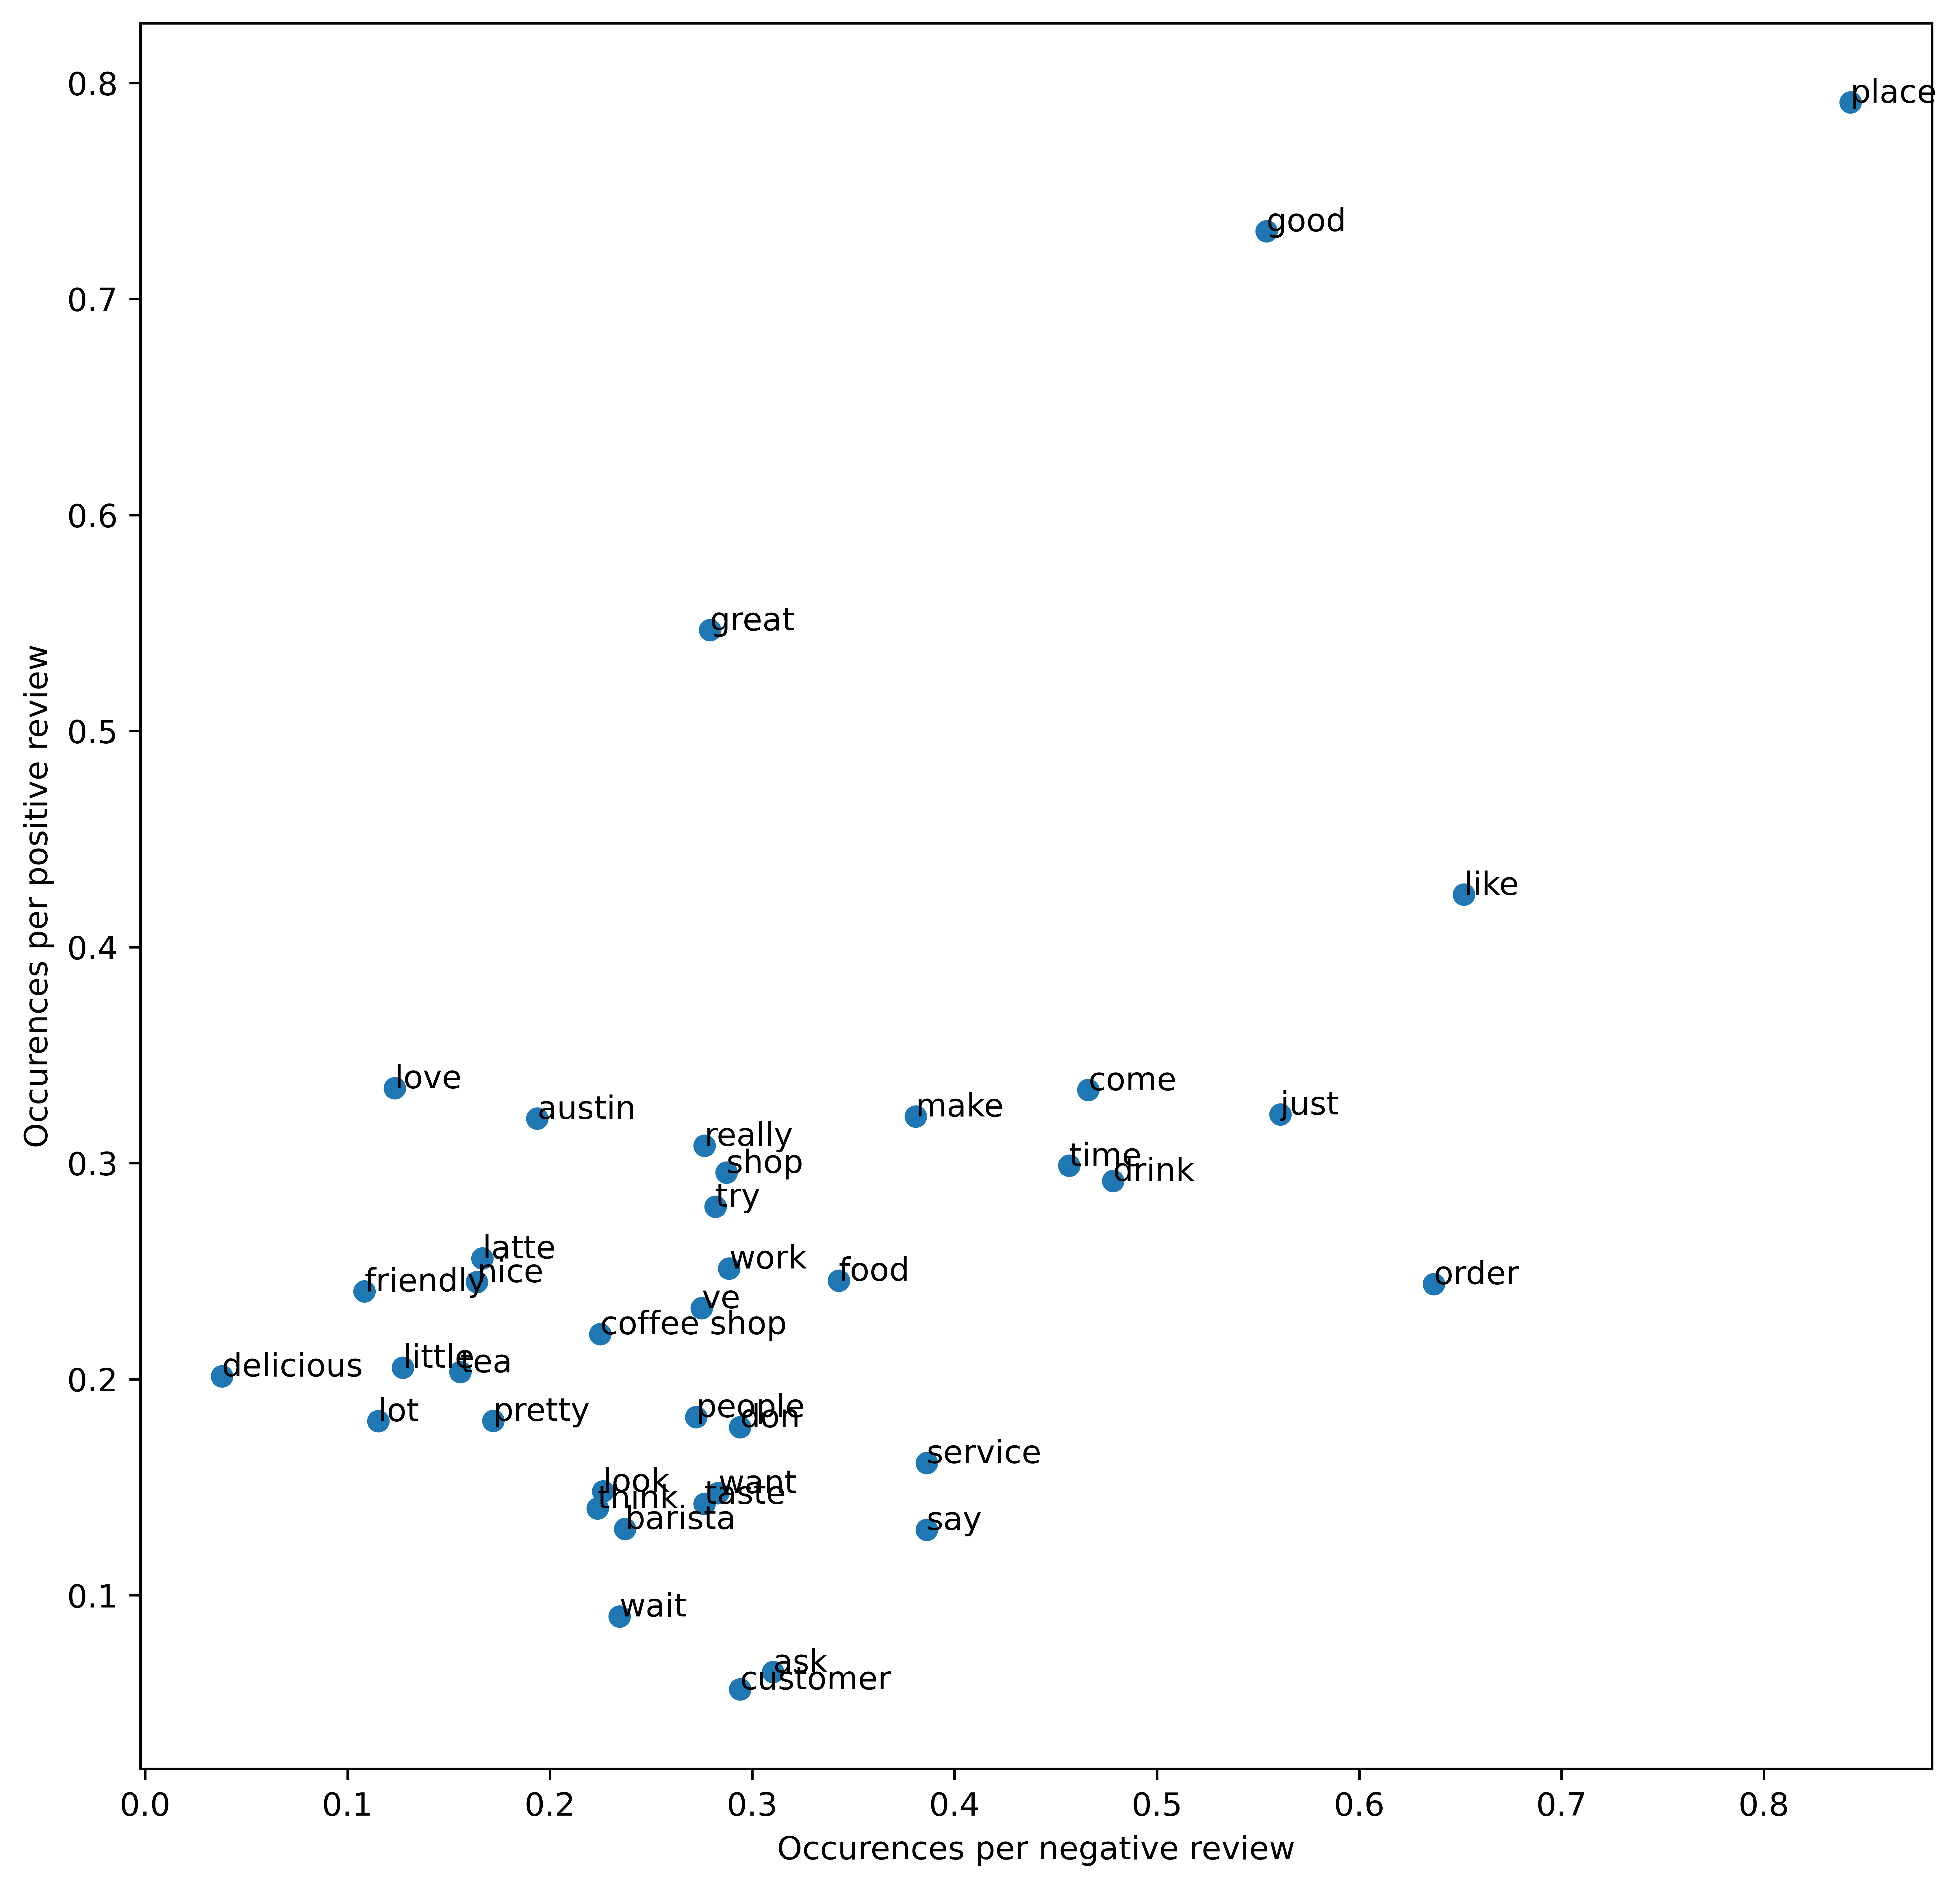

In [473]:

plt.figure(figsize=(10, 10), dpi=800)

plt.scatter(neg_scores, pos_scores)


plt.ylabel("Occurences per positive review")
plt.xlabel("Occurences per negative review")

for i, txt in enumerate(top_words):
    plt.annotate(txt, (neg_scores[i], pos_scores[i]), size=10)
    

plt.savefig("text_scatter.png", format='png', dpi=800)